# Breeden-Litzenberger Model Implementation
# Extracting Risk-Neutral Probability Distributions from Option Prices

This notebook implements the **Breeden-Litzenberger (1978)** method to recover the
risk-neutral probability density (RND) implied by market option prices on SPY (S&P 500 ETF).

**Pipeline overview:**
1. Fetch live option chain data for SPY via yfinance
2. Clean and filter for liquid, near-term options (~30 days to expiry)
3. Compute implied volatilities and construct the volatility smile
4. Interpolate/extrapolate the smile using a clamped cubic spline (Malz 2014)
5. Build a fine-grid call price function via Black-Scholes with the interpolated vols
6. Apply Breeden-Litzenberger finite differencing to extract the RND
7. Compare the market-implied distribution against the theoretical lognormal (Black-Scholes)
8. Analyse tail risk, skewness, and kurtosis

## Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.interpolate import CubicSpline
from scipy.stats import norm, lognorm
from scipy.optimize import brentq
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Compatibility: numpy >= 2.0 renamed trapz -> trapezoid
trapz = np.trapezoid if hasattr(np, 'trapezoid') else np.trapz

print("All imports loaded successfully.")

All imports loaded successfully.


## Black-Scholes Pricing Functions

Core pricing engine used throughout. The BS formula gives us:
- A way to **invert** market prices into implied volatilities
- A way to **reconstruct** call prices from interpolated vols on a fine strike grid
- The **theoretical lognormal density** to compare against the market-implied RND

In [2]:
def bs_d1(S, K, T, r, q, sigma):
    """Compute Black-Scholes d1 parameter."""
    return (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def bs_d2(S, K, T, r, q, sigma):
    """Compute Black-Scholes d2 parameter."""
    return bs_d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)

def bs_call_price(S, K, T, r, q, sigma):
    """
    Black-Scholes European call price.
    
    Parameters:
        S     : Current underlying price
        K     : Strike price (scalar or array)
        T     : Time to expiration (years)
        r     : Risk-free rate (continuously compounded)
        q     : Dividend yield (continuously compounded)
        sigma : Volatility (scalar or array matching K)
    
    Returns:
        Call option price(s)
    """
    d1 = bs_d1(S, K, T, r, q, sigma)
    d2 = d1 - sigma * np.sqrt(T)
    return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def bs_put_price(S, K, T, r, q, sigma):
    """Black-Scholes European put price via put-call parity."""
    return bs_call_price(S, K, T, r, q, sigma) - S * np.exp(-q * T) + K * np.exp(-r * T)

def bs_vega(S, K, T, r, q, sigma):
    """Black-Scholes vega (sensitivity of price to volatility)."""
    d1 = bs_d1(S, K, T, r, q, sigma)
    return S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

def implied_vol_call(market_price, S, K, T, r, q, lower=0.001, upper=5.0):
    """
    Invert the BS formula to find implied volatility from a market call price.
    Uses Brent's method (guaranteed convergence for bracketed roots).
    """
    intrinsic = max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    if market_price <= intrinsic + 1e-10:
        return np.nan
    
    def objective(sigma):
        return bs_call_price(S, K, T, r, q, sigma) - market_price
    
    try:
        if objective(lower) * objective(upper) > 0:
            return np.nan
        return brentq(objective, lower, upper, xtol=1e-12, maxiter=200)
    except (ValueError, RuntimeError):
        return np.nan

def implied_vol_put(market_price, S, K, T, r, q, lower=0.001, upper=5.0):
    """Invert BS for implied vol from a market put price."""
    # Convert to call price via put-call parity, then solve
    call_price = market_price + S * np.exp(-q * T) - K * np.exp(-r * T)
    return implied_vol_call(call_price, S, K, T, r, q, lower, upper)

print("Black-Scholes pricing functions defined.")

Black-Scholes pricing functions defined.


## Step 1: Fetch Market Data

In [3]:
# --- Configuration ---
TICKER = "SPY"
TARGET_DTE = 30  # Target ~30 days to expiry

# Market parameters (approximate current values)
RISK_FREE_RATE = 0.043   # ~4.3% (3-month T-bill yield)
DIVIDEND_YIELD = 0.013   # ~1.3% (SPY trailing dividend yield)

# --- Fetch underlying price ---
spy = yf.Ticker(TICKER)
hist = spy.history(period="5d")
S0 = hist['Close'].iloc[-1]
print(f"Underlying: {TICKER}")
print(f"Current price (S0): ${S0:.2f}")

# --- Select the nearest expiry to our target DTE ---
expiry_dates = spy.options
print(f"\nAvailable expiries: {len(expiry_dates)}")

from datetime import datetime, timedelta
today = datetime.today()
target_date = today + timedelta(days=TARGET_DTE)

# Find expiry closest to target
expiry_dtes = []
for exp_str in expiry_dates:
    exp_date = datetime.strptime(exp_str, "%Y-%m-%d")
    dte = (exp_date - today).days
    expiry_dtes.append((exp_str, dte, abs(dte - TARGET_DTE)))

expiry_dtes.sort(key=lambda x: x[2])
selected_expiry = expiry_dtes[0][0]
actual_dte = expiry_dtes[0][1]
T = actual_dte / 365.0  # Time to expiry in years

print(f"Selected expiry: {selected_expiry} ({actual_dte} DTE)")
print(f"T = {T:.4f} years")

# --- Fetch option chain ---
chain = spy.option_chain(selected_expiry)
calls_raw = chain.calls.copy()
puts_raw = chain.puts.copy()

print(f"\nRaw calls: {len(calls_raw)} strikes")
print(f"Raw puts:  {len(puts_raw)} strikes")

Underlying: SPY
Current price (S0): $676.63

Available expiries: 34
Selected expiry: 2026-03-20 (30 DTE)
T = 0.0822 years



Raw calls: 210 strikes
Raw puts:  210 strikes


## Step 2: Clean and Filter Option Data

We need to:
- Use **mid prices** (average of bid/ask) to reduce microstructure noise
- Filter out illiquid options (zero bid, wide spreads, low volume/OI)
- Focus on strikes within a reasonable range around ATM (moneyness 0.7-1.3)
- Use **OTM options only**: OTM puts for strikes below ATM, OTM calls for strikes above ATM  
  (OTM options are more liquid and have tighter spreads than their ITM counterparts)

In [4]:
def clean_options(df, option_type, S, min_price=0.05, min_oi=10, moneyness_range=(0.70, 1.30)):
    """
    Clean and filter option data.
    
    Handles both live market (bid/ask available) and after-hours (lastPrice only).
    """
    df = df.copy()
    
    # Use mid price if bid/ask are available, otherwise fall back to lastPrice
    has_quotes = (df['bid'] > 0) & (df['ask'] > 0)
    df['mid'] = np.where(has_quotes, (df['bid'] + df['ask']) / 2, df['lastPrice'])
    df['spread'] = np.where(has_quotes, df['ask'] - df['bid'], np.nan)
    df['moneyness'] = df['strike'] / S
    df['has_live_quotes'] = has_quotes
    
    # Filter
    mask = (
        (df['mid'] >= min_price) &
        (df['openInterest'] >= min_oi) &
        (df['moneyness'] >= moneyness_range[0]) &
        (df['moneyness'] <= moneyness_range[1])
    )
    df = df[mask].copy()
    
    return df[['strike', 'bid', 'ask', 'mid', 'spread', 'lastPrice', 'volume', 
               'openInterest', 'impliedVolatility', 'moneyness', 'has_live_quotes']].sort_values('strike')

# Clean both chains
calls = clean_options(calls_raw, 'call', S0)
puts = clean_options(puts_raw, 'put', S0)

quote_status = "LIVE bid/ask" if calls['has_live_quotes'].any() else "lastPrice (market closed)"
print(f"Price source: {quote_status}")
print(f"Filtered calls: {len(calls)} strikes")
print(f"Filtered puts:  {len(puts)} strikes")
if len(calls) > 0:
    print(f"\nCalls strike range: ${calls['strike'].min():.0f} - ${calls['strike'].max():.0f}")
if len(puts) > 0:
    print(f"Puts strike range:  ${puts['strike'].min():.0f} - ${puts['strike'].max():.0f}")
print(f"ATM strike ~ ${S0:.0f}")

# Preview
print("\n--- Sample Calls (near ATM) ---")
atm_mask = (calls['moneyness'] > 0.97) & (calls['moneyness'] < 1.03)
print(calls[atm_mask][['strike', 'mid', 'openInterest', 'moneyness']].to_string(index=False))

Price source: LIVE bid/ask
Filtered calls: 112 strikes
Filtered puts:  138 strikes

Calls strike range: $475 - $760
Puts strike range:  $475 - $800
ATM strike ~ $677

--- Sample Calls (near ATM) ---
 strike    mid  openInterest  moneyness
  658.0 29.570            26   0.972466
  660.0 27.880         10569   0.975422
  662.0 26.375            12   0.978378
  664.0 24.890            11   0.981334
  665.0 24.120          8879   0.982812
  666.0 23.360            22   0.984290
  667.0 22.650           154   0.985768
  668.0 21.910            15   0.987246
  669.0 21.195            10   0.988724
  670.0 20.560         20815   0.990201
  671.0 19.815            23   0.991679
  672.0 19.065            32   0.993157
  674.0 17.775            25   0.996113
  675.0 17.075          7880   0.997591
  676.0 16.495            61   0.999069
  677.0 15.780           597   1.000547
  678.0 15.140           354   1.002025
  679.0 14.515           979   1.003503
  680.0 13.975         13279   1.004981
 

## Step 3: Compute Implied Volatilities and Build the Volatility Smile

We compute IV by **inverting the Black-Scholes formula** using Brent's root-finding method.

For the smile construction, we follow market convention:
- Use **OTM puts** for K < S (lower strikes) and **OTM calls** for K > S (upper strikes)
- At-the-money, we average both

This gives us the cleanest implied volatility surface since OTM options are more liquid.

In [5]:
r = RISK_FREE_RATE
q = DIVIDEND_YIELD

# Compute implied vols from market mid prices
call_ivs = []
for _, row in calls.iterrows():
    iv = implied_vol_call(row['mid'], S0, row['strike'], T, r, q)
    call_ivs.append(iv)
calls = calls.copy()
calls['iv_computed'] = call_ivs

put_ivs = []
for _, row in puts.iterrows():
    iv = implied_vol_put(row['mid'], S0, row['strike'], T, r, q)
    put_ivs.append(iv)
puts = puts.copy()
puts['iv_computed'] = put_ivs

# Drop failed IV computations
calls = calls.dropna(subset=['iv_computed'])
puts = puts.dropna(subset=['iv_computed'])

print(f"Valid IVs: {len(calls)} calls, {len(puts)} puts")

# Build combined smile: OTM puts (K < S0) + OTM calls (K >= S0)
otm_puts = puts[puts['strike'] < S0][['strike', 'iv_computed', 'moneyness']].copy()
otm_puts = otm_puts.rename(columns={'iv_computed': 'iv'})
otm_puts['source'] = 'OTM Put'

otm_calls = calls[calls['strike'] >= S0][['strike', 'iv_computed', 'moneyness']].copy()
otm_calls = otm_calls.rename(columns={'iv_computed': 'iv'})
otm_calls['source'] = 'OTM Call'

smile = pd.concat([otm_puts, otm_calls], ignore_index=True).sort_values('strike')
smile = smile.drop_duplicates(subset='strike', keep='first')

# Remove any extreme outliers (IV > 1.5 or < 0.01)
smile = smile[(smile['iv'] > 0.01) & (smile['iv'] < 1.5)]

print(f"Volatility smile: {len(smile)} data points")
if len(smile) > 0:
    print(f"Strike range: ${smile['strike'].min():.0f} - ${smile['strike'].max():.0f}")
    print(f"IV range: {smile['iv'].min():.4f} - {smile['iv'].max():.4f}")
    atm_idx = smile['moneyness'].sub(1).abs().idxmin()
    print(f"ATM IV ~ {smile.loc[atm_idx, 'iv']:.4f} ({smile.loc[atm_idx, 'iv']*100:.2f}%)")
else:
    print("WARNING: No valid smile data points. Check data source.")

Valid IVs: 112 calls, 138 puts
Volatility smile: 150 data points
Strike range: $475 - $760
IV range: 0.1333 - 0.5347
ATM IV ~ 0.1958 (19.58%)


In [6]:
# --- Plot the raw volatility smile ---
fig = go.Figure()

# Color by source
for source, color in [('OTM Put', '#EF553B'), ('OTM Call', '#636EFA')]:
    mask = smile['source'] == source
    fig.add_trace(go.Scatter(
        x=smile[mask]['moneyness'],
        y=smile[mask]['iv'] * 100,
        mode='markers',
        name=source,
        marker=dict(size=7, color=color),
        hovertemplate='K=$%{customdata[0]:.0f}<br>Moneyness=%{x:.3f}<br>IV=%{y:.2f}%',
        customdata=smile[mask][['strike']].values
    ))

fig.add_vline(x=1.0, line_dash="dash", line_color="gray", annotation_text="ATM")
fig.update_layout(
    title=f"Implied Volatility Smile - {TICKER} ({selected_expiry}, {actual_dte} DTE)",
    xaxis_title="Moneyness (K/S)",
    yaxis_title="Implied Volatility (%)",
    template="plotly_white",
    width=900, height=500,
    legend=dict(x=0.02, y=0.98)
)
fig.show()

## Step 4: Interpolate and Extrapolate the Volatility Smile

Following **Malz (2014, Sec. 2.1–2.2)**, we fit a **clamped cubic spline** to the implied volatility data:

- **Clamped** means the first derivative is set to zero at the boundary knots (Malz 2014, Eq. 5–6). This ensures 
  flat extrapolation beyond the observed strikes, which prevents no-arbitrage violations 
  (the call valuation function stays monotonically decreasing and convex).
- **Cubic spline** ensures C² continuity (continuous first and second derivatives), which is 
  essential since the BL method requires the second derivative of call prices 
  (Breeden & Litzenberger 1978, Eq. 2; Jackwerth 2004, Eq. 7).
- Beyond observed strikes, we extrapolate at constant IV (flat wings).

The resulting **call valuation function** is defined as (Malz 2014, Eq. 4):

$$c(t, X, \tau) = v[S_t, X, \tau, \sigma(X), r, q]$$

where $v[\cdot]$ is the Black-Scholes formula and $\sigma(X)$ is the interpolated smile.

In [7]:
# --- Fit clamped cubic spline to the volatility smile ---
strikes_data = smile['strike'].values
ivs_data = smile['iv'].values

# Clamped cubic spline: first derivative = 0 at boundaries (flat extrapolation)
# bc_type=((1, 0), (1, 0)) means first derivative = 0 at both endpoints
vol_spline = CubicSpline(strikes_data, ivs_data, bc_type=((1, 0.0), (1, 0.0)))

# Define the interpolated/extrapolated vol function with flat wings
K_min_data = strikes_data[0]
K_max_data = strikes_data[-1]
iv_min = ivs_data[0]
iv_max = ivs_data[-1]

def sigma_interp(K):
    """
    Interpolated implied volatility function.
    - Inside observed range: clamped cubic spline
    - Outside observed range: flat extrapolation at boundary IV
    """
    K = np.atleast_1d(K)
    result = np.empty_like(K, dtype=float)
    
    below = K < K_min_data
    above = K > K_max_data
    inside = ~below & ~above
    
    result[below] = iv_min
    result[above] = iv_max
    result[inside] = vol_spline(K[inside])
    
    # Ensure IV is always positive
    result = np.maximum(result, 0.001)
    
    return result

# --- Build the call valuation function on a fine grid ---
# This is the key: c(t, X, tau) = v(S, X, tau, sigma(X), r, q)
# where sigma(X) comes from the interpolated smile

# Fine grid extending well beyond observed strikes
F = S0 * np.exp((r - q) * T)  # Forward price
K_low = S0 * 0.50    # 50% of spot
K_high = S0 * 1.50   # 150% of spot
N_grid = 2000
K_fine = np.linspace(K_low, K_high, N_grid)

# Compute interpolated vols and call prices on fine grid
sigma_fine = sigma_interp(K_fine)
C_fine = bs_call_price(S0, K_fine, T, r, q, sigma_fine)

print(f"Forward price: F = ${F:.2f}")
print(f"Fine grid: {N_grid} points from ${K_low:.0f} to ${K_high:.0f}")
print(f"Grid spacing: dK = ${(K_high - K_low) / N_grid:.4f}")

# --- Plot: Interpolated smile overlaid on raw data ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=smile['strike'], y=smile['iv'] * 100,
    mode='markers', name='Market IV (raw)',
    marker=dict(size=7, color='#EF553B')
))

fig.add_trace(go.Scatter(
    x=K_fine, y=sigma_fine * 100,
    mode='lines', name='Clamped Cubic Spline',
    line=dict(color='#636EFA', width=2)
))

fig.add_vline(x=S0, line_dash="dash", line_color="gray", annotation_text="Spot")
fig.add_vline(x=K_min_data, line_dash="dot", line_color="orange", annotation_text="Data min")
fig.add_vline(x=K_max_data, line_dash="dot", line_color="orange", annotation_text="Data max")

fig.update_layout(
    title=f"Volatility Smile: Raw Data vs Clamped Cubic Spline",
    xaxis_title="Strike Price ($)",
    yaxis_title="Implied Volatility (%)",
    template="plotly_white",
    width=900, height=500
)
fig.show()

Forward price: F = $678.30
Fine grid: 2000 points from $338 to $1015
Grid spacing: dK = $0.3383


In [8]:
# --- Plot the call valuation function ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=K_fine, y=C_fine,
    mode='lines', name='Call Price c(K)',
    line=dict(color='#636EFA', width=2)
))

# Overlay actual market mid prices for calls
fig.add_trace(go.Scatter(
    x=calls['strike'], y=calls['mid'],
    mode='markers', name='Market Call Prices',
    marker=dict(size=5, color='#EF553B')
))

fig.add_vline(x=S0, line_dash="dash", line_color="gray", annotation_text="Spot")
fig.update_layout(
    title="Call Valuation Function c(K) from Interpolated Smile",
    xaxis_title="Strike Price ($)",
    yaxis_title="Call Price ($)",
    template="plotly_white",
    width=900, height=500
)
fig.show()

## Step 5: Breeden-Litzenberger — Extract the Risk-Neutral Distribution

This is the core result. From the **Breeden-Litzenberger (1978) Theorem 1**, also presented as **Jackwerth (2004, Eq. 7)** and **Malz (2014, Eq. 2–3)**:

**Risk-neutral CDF** (Malz 2014, Eq. 2):

$$\tilde{\Pi}_t(X) = 1 + e^{r\tau} \frac{\partial c}{\partial X}$$

**Risk-neutral PDF** (Breeden & Litzenberger 1978, Eq. 2; Malz 2014, Eq. 3):

$$\tilde{\pi}_t(X) = e^{r\tau} \frac{\partial^2 c}{\partial X^2}$$

We approximate these with **central finite differences** (Malz 2014, Sec. 2.3):

$$\tilde{\Pi}_t(X) \approx 1 + e^{r\tau} \frac{1}{\Delta}\left[c\left(X + \tfrac{\Delta}{2}\right) - c\left(X - \tfrac{\Delta}{2}\right)\right]$$

$$\tilde{\pi}_t(X) \approx e^{r\tau} \frac{1}{\Delta^2}\left[c(X + \Delta) + c(X - \Delta) - 2\,c(X)\right]$$

The second formula is the **butterfly spread** decomposition — in the limit $\Delta \to 0$, the butterfly payoff converges to an Arrow-Debreu security (Breeden & Litzenberger 1978, Theorem 1).

The step size $\Delta$ is a smoothing parameter (Malz 2014, Sec. 2.4) — too small and noise dominates, too large and we lose resolution. We use $\Delta = 0.025 \times F$.

In [9]:
def call_value(K_arr):
    """
    Compute BS call prices at arbitrary strikes using the interpolated vol smile.
    This is the call valuation function c(t, X, tau) from Malz (2014) eq. (4).
    """
    K_arr = np.atleast_1d(K_arr)
    sigmas = sigma_interp(K_arr)
    return bs_call_price(S0, K_arr, T, r, q, sigmas)

def breeden_litzenberger(K_grid, delta_frac=0.025):
    """
    Apply the Breeden-Litzenberger method to extract:
    - Risk-neutral CDF (cumulative distribution)
    - Risk-neutral PDF (probability density)
    
    Parameters:
        K_grid     : Array of strike prices to evaluate
        delta_frac : Step size as fraction of forward price (Malz 2014 recommends ~0.025)
    
    Returns:
        K_grid : Strike prices
        cdf    : Risk-neutral CDF at each strike
        pdf    : Risk-neutral PDF at each strike
    """
    Delta = delta_frac * F  # Absolute step size in dollars
    discount = np.exp(r * T)  # Future value factor
    
    # --- CDF via first derivative (central difference) ---
    c_up_half = call_value(K_grid + Delta / 2)
    c_dn_half = call_value(K_grid - Delta / 2)
    cdf = 1.0 + discount * (c_up_half - c_dn_half) / Delta
    
    # --- PDF via second derivative (central difference) ---
    c_center = call_value(K_grid)
    c_up = call_value(K_grid + Delta)
    c_dn = call_value(K_grid - Delta)
    pdf = discount * (c_up + c_dn - 2.0 * c_center) / (Delta**2)
    
    return K_grid, cdf, pdf

# --- Compute the RND ---
K_rnd = np.linspace(S0 * 0.70, S0 * 1.30, 1500)
_, rn_cdf, rn_pdf = breeden_litzenberger(K_rnd, delta_frac=0.025)

# Ensure non-negative densities (numerical artifact cleanup)
rn_pdf = np.maximum(rn_pdf, 0)

# Normalise the PDF so it integrates to 1 (numerical correction)
total_mass = trapz(rn_pdf, K_rnd)
rn_pdf_norm = rn_pdf / total_mass

print(f"Step size Delta = {0.025 * F:.2f} (= 2.5% of forward ${F:.2f})")
print(f"PDF total mass before normalisation: {total_mass:.6f}")
print(f"PDF total mass after normalisation:  {trapz(rn_pdf_norm, K_rnd):.6f}")
print(f"CDF range: [{rn_cdf.min():.4f}, {rn_cdf.max():.4f}]")

Step size Delta = 16.96 (= 2.5% of forward $678.30)
PDF total mass before normalisation: 0.994945
PDF total mass after normalisation:  1.000000
CDF range: [0.0047, 1.0000]


## Step 6: Lognormal Benchmark (Black-Scholes Theoretical Distribution)

Under Black-Scholes assumptions, the risk-neutral distribution of $S_T$ is **lognormal**:

$$\ln S_T \sim \mathcal{N}\left(\ln S_0 + (r - q - \tfrac{\sigma^2}{2})T,\;\; \sigma^2 T\right)$$

We use the ATM implied volatility as $\sigma$ to build this benchmark. Any deviation between 
the market-implied RND and this lognormal represents the market's view that returns are 
**not** normally distributed — revealing skew, excess kurtosis, and tail risk.

In [10]:
# --- Lognormal benchmark from Black-Scholes ---
# ATM implied vol
sigma_atm = float(sigma_interp(np.array([S0]))[0])
print(f"ATM implied volatility: {sigma_atm:.4f} ({sigma_atm*100:.2f}%)")

# Under risk-neutral measure, ln(S_T) ~ N(mu_ln, sigma_ln^2)
mu_ln = np.log(S0) + (r - q - 0.5 * sigma_atm**2) * T
sigma_ln = sigma_atm * np.sqrt(T)

# Lognormal PDF: f(x) = (1/(x * sigma_ln * sqrt(2*pi))) * exp(-(ln(x) - mu_ln)^2 / (2*sigma_ln^2))
lognorm_pdf = (1.0 / (K_rnd * sigma_ln * np.sqrt(2 * np.pi))) * \
              np.exp(-0.5 * ((np.log(K_rnd) - mu_ln) / sigma_ln)**2)

# Lognormal CDF
lognorm_cdf = norm.cdf((np.log(K_rnd) - mu_ln) / sigma_ln)

print(f"Lognormal mean (E[S_T]): ${np.exp(mu_ln + 0.5*sigma_ln**2):.2f}")
print(f"Forward price:           ${F:.2f}")
print(f"Lognormal std dev:       ${np.exp(mu_ln + 0.5*sigma_ln**2) * np.sqrt(np.exp(sigma_ln**2) - 1):.2f}")

ATM implied volatility: 0.1960 (19.60%)
Lognormal mean (E[S_T]): $678.30
Forward price:           $678.30
Lognormal std dev:       $38.14


In [11]:
# =============================================================================
# MAIN RESULT: Risk-Neutral Density vs Lognormal Benchmark
# =============================================================================

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Risk-Neutral PDF (Probability Density)",
        "Risk-Neutral CDF (Cumulative Probability)",
        "PDF Difference (Market-Implied minus Lognormal)",
        "Log-Return Density"
    ),
    vertical_spacing=0.12,
    horizontal_spacing=0.08
)

# --- (1) PDF comparison ---
fig.add_trace(go.Scatter(
    x=K_rnd, y=rn_pdf_norm,
    mode='lines', name='Market-Implied RND',
    line=dict(color='#EF553B', width=2.5),
    legendgroup='pdf'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=K_rnd, y=lognorm_pdf,
    mode='lines', name='Lognormal (BS)',
    line=dict(color='#636EFA', width=2, dash='dash'),
    legendgroup='pdf'
), row=1, col=1)

fig.add_vline(x=F, line_dash="dot", line_color="gray", row=1, col=1)

# --- (2) CDF comparison ---
fig.add_trace(go.Scatter(
    x=K_rnd, y=rn_cdf,
    mode='lines', name='Market CDF',
    line=dict(color='#EF553B', width=2.5),
    legendgroup='cdf', showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=K_rnd, y=lognorm_cdf,
    mode='lines', name='Lognormal CDF',
    line=dict(color='#636EFA', width=2, dash='dash'),
    legendgroup='cdf', showlegend=False
), row=1, col=2)

# --- (3) PDF difference (where does the market disagree with BS?) ---
pdf_diff = rn_pdf_norm - lognorm_pdf
fig.add_trace(go.Scatter(
    x=K_rnd, y=pdf_diff,
    mode='lines', name='Density Difference',
    line=dict(color='#AB63FA', width=2),
    fill='tozeroy',
    fillcolor='rgba(171, 99, 250, 0.15)'
), row=2, col=1)

fig.add_hline(y=0, line_dash="dash", line_color="gray", row=2, col=1)
fig.add_vline(x=F, line_dash="dot", line_color="gray", row=2, col=1)

# --- (4) Log-return density ---
# Transform from price space to return space: R = ln(S_T / S_0)
returns = np.log(K_rnd / S0) * 100  # Percentage log returns

# Transform PDF: f_R(r) = S_0 * exp(r) * f_S(S_0 * exp(r))
# But since we already have pdf on K grid, just replot vs returns
fig.add_trace(go.Scatter(
    x=returns, y=rn_pdf_norm * K_rnd,  # Jacobian: dK = K * dR
    mode='lines', name='Market (Returns)',
    line=dict(color='#EF553B', width=2.5),
    showlegend=False
), row=2, col=2)

fig.add_trace(go.Scatter(
    x=returns, y=lognorm_pdf * K_rnd,
    mode='lines', name='Lognormal (Returns)',
    line=dict(color='#636EFA', width=2, dash='dash'),
    showlegend=False
), row=2, col=2)

fig.add_vline(x=0, line_dash="dot", line_color="gray", row=2, col=2)

# Layout
fig.update_xaxes(title_text="Strike Price ($)", row=1, col=1)
fig.update_xaxes(title_text="Strike Price ($)", row=1, col=2)
fig.update_xaxes(title_text="Strike Price ($)", row=2, col=1)
fig.update_xaxes(title_text="Log Return (%)", row=2, col=2)
fig.update_yaxes(title_text="Density", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=2)
fig.update_yaxes(title_text="Density Diff", row=2, col=1)
fig.update_yaxes(title_text="Density", row=2, col=2)

fig.update_layout(
    title=f"Breeden-Litzenberger Risk-Neutral Distribution — {TICKER} ({selected_expiry}, {actual_dte} DTE)",
    template="plotly_white",
    width=1100, height=800,
    showlegend=True,
    legend=dict(x=0.02, y=0.98)
)
fig.show()

## Step 7: Statistical Analysis — Moments, Tail Risk, and Skewness

We compute the first four moments of the market-implied distribution and compare them 
to the lognormal benchmark. Key metrics:
- **Mean**: Expected future price under the risk-neutral measure (should match the forward price)
- **Variance/Std**: Width of the distribution
- **Skewness**: Asymmetry — negative skew means the market prices in larger downside moves
- **Excess Kurtosis**: Fat tails — positive means the market expects more extreme moves than lognormal
- **Tail probabilities**: Probability of large declines (e.g., -10%, -20%)

In [12]:
def compute_moments(K, pdf_vals):
    """Compute moments of a distribution given on a discrete grid."""
    total = trapz(pdf_vals, K)
    f = pdf_vals / total
    
    mean = trapz(K * f, K)
    var = trapz((K - mean)**2 * f, K)
    std = np.sqrt(var)
    skew = trapz(((K - mean) / std)**3 * f, K)
    kurt = trapz(((K - mean) / std)**4 * f, K) - 3.0
    
    return {'mean': mean, 'std': std, 'variance': var, 'skewness': skew, 'excess_kurtosis': kurt}

# Compute moments for both distributions
market_moments = compute_moments(K_rnd, rn_pdf_norm)
lognorm_moments = compute_moments(K_rnd, lognorm_pdf)

# --- Display comparison table ---
print("=" * 70)
print(f"  DISTRIBUTION MOMENTS COMPARISON — {TICKER} ({selected_expiry})")
print("=" * 70)
print(f"{'Statistic':<25} {'Market-Implied':>18} {'Lognormal (BS)':>18}")
print("-" * 70)
print(f"{'Mean E[S_T]':<25} ${market_moments['mean']:>17.2f} ${lognorm_moments['mean']:>17.2f}")
print(f"{'Std Dev':<25} ${market_moments['std']:>17.2f} ${lognorm_moments['std']:>17.2f}")
print(f"{'Skewness':<25} {market_moments['skewness']:>18.4f} {lognorm_moments['skewness']:>18.4f}")
print(f"{'Excess Kurtosis':<25} {market_moments['excess_kurtosis']:>18.4f} {lognorm_moments['excess_kurtosis']:>18.4f}")
print(f"{'Forward Price':<25} ${F:>17.2f}")
print("-" * 70)

# --- Tail probabilities ---
print(f"\n{'TAIL RISK ANALYSIS':^70}")
print("=" * 70)
print(f"{'Event':<35} {'Market Prob':>15} {'Lognormal Prob':>15}")
print("-" * 70)

for pct_decline in [-5, -10, -15, -20, -25]:
    K_level = S0 * (1 + pct_decline / 100)
    mask = K_rnd <= K_level
    mkt_prob = trapz(rn_pdf_norm[mask], K_rnd[mask]) if mask.any() else 0.0
    ln_prob = norm.cdf((np.log(K_level) - mu_ln) / sigma_ln)
    label = f"Decline >= {abs(pct_decline)}% (S_T < ${K_level:.0f})"
    print(f"{label:<35} {mkt_prob:>14.4%} {ln_prob:>14.4%}")

print()
for pct_gain in [5, 10, 15, 20]:
    K_level = S0 * (1 + pct_gain / 100)
    mask = K_rnd >= K_level
    mkt_prob = trapz(rn_pdf_norm[mask], K_rnd[mask]) if mask.any() else 0.0
    ln_prob = 1.0 - norm.cdf((np.log(K_level) - mu_ln) / sigma_ln)
    label = f"Gain >= {pct_gain}% (S_T > ${K_level:.0f})"
    print(f"{label:<35} {mkt_prob:>14.4%} {ln_prob:>14.4%}")

print("=" * 70)

  DISTRIBUTION MOMENTS COMPARISON — SPY (2026-03-20)
Statistic                     Market-Implied     Lognormal (BS)
----------------------------------------------------------------------
Mean E[S_T]               $           679.63 $           678.30
Std Dev                   $            38.23 $            38.14
Skewness                             -1.2197             0.1686
Excess Kurtosis                       2.1391             0.0495
Forward Price             $           678.30
----------------------------------------------------------------------

                          TAIL RISK ANALYSIS                          
Event                                   Market Prob  Lognormal Prob
----------------------------------------------------------------------
Decline >= 5% (S_T < $643)                15.0284%       17.6518%
Decline >= 10% (S_T < $609)                5.7489%        2.9311%
Decline >= 15% (S_T < $575)                2.0669%        0.1817%
Decline >= 20% (S_T < $541)    

## Step 8: Sensitivity to the Smoothing Parameter $\Delta$

The finite difference step size $\Delta$ trades off resolution vs smoothness (Malz 2014, Sec. 2.4). 
Malz recommends $\Delta = \alpha \cdot F$ with $\alpha \approx 0.025$ as a baseline. 
We show how the extracted density changes for different values of $\alpha \in \{0.01, 0.025, 0.05, 0.10\}$.

In [13]:
# --- Sensitivity to Delta ---
fig = go.Figure()

delta_fracs = [0.010, 0.025, 0.050, 0.100]
colors = ['#FF6692', '#EF553B', '#636EFA', '#00CC96']

for delta_frac, color in zip(delta_fracs, colors):
    _, _, pdf_test = breeden_litzenberger(K_rnd, delta_frac=delta_frac)
    pdf_test = np.maximum(pdf_test, 0)
    pdf_test = pdf_test / trapz(pdf_test, K_rnd)
    
    fig.add_trace(go.Scatter(
        x=K_rnd, y=pdf_test,
        mode='lines',
        name=f'Delta = {delta_frac:.3f} (${delta_frac * F:.1f})',
        line=dict(color=color, width=2)
    ))

fig.add_trace(go.Scatter(
    x=K_rnd, y=lognorm_pdf,
    mode='lines', name='Lognormal (BS)',
    line=dict(color='gray', width=1.5, dash='dash')
))

fig.add_vline(x=F, line_dash="dot", line_color="lightgray")
fig.update_layout(
    title=f"Sensitivity of Risk-Neutral Density to Step Size Delta",
    xaxis_title="Strike Price ($)",
    yaxis_title="Density",
    template="plotly_white",
    width=900, height=500,
    legend=dict(x=0.70, y=0.98)
)
fig.show()

## Step 9: Tail Risk Visualisation

Highlight where the market prices significantly more or less probability than the 
lognormal model. The **left tail** (large declines) is typically heavier in market-implied 
distributions — this is the **volatility skew** in action.

In [14]:
# --- Tail risk: shaded area comparison ---
fig = go.Figure()

# Full distributions
fig.add_trace(go.Scatter(
    x=K_rnd, y=rn_pdf_norm,
    mode='lines', name='Market-Implied',
    line=dict(color='#EF553B', width=2.5)
))

fig.add_trace(go.Scatter(
    x=K_rnd, y=lognorm_pdf,
    mode='lines', name='Lognormal (BS)',
    line=dict(color='#636EFA', width=2, dash='dash')
))

# Shade left tail (decline > 10%)
K_left_tail = S0 * 0.90
left_mask = K_rnd <= K_left_tail
if left_mask.any():
    fig.add_trace(go.Scatter(
        x=K_rnd[left_mask], y=rn_pdf_norm[left_mask],
        fill='tozeroy', fillcolor='rgba(239, 85, 59, 0.3)',
        line=dict(width=0), showlegend=True,
        name=f'Market left tail (>{10}% decline)'
    ))
    fig.add_trace(go.Scatter(
        x=K_rnd[left_mask], y=lognorm_pdf[left_mask],
        fill='tozeroy', fillcolor='rgba(99, 110, 250, 0.15)',
        line=dict(width=0), showlegend=True,
        name=f'Lognormal left tail'
    ))

# Shade right tail (gain > 10%)
K_right_tail = S0 * 1.10
right_mask = K_rnd >= K_right_tail
if right_mask.any():
    fig.add_trace(go.Scatter(
        x=K_rnd[right_mask], y=rn_pdf_norm[right_mask],
        fill='tozeroy', fillcolor='rgba(0, 204, 150, 0.3)',
        line=dict(width=0), showlegend=True,
        name=f'Market right tail (>{10}% gain)'
    ))

fig.add_vline(x=S0, line_dash="dash", line_color="gray", annotation_text="Current Price")
fig.add_vline(x=K_left_tail, line_dash="dot", line_color="#EF553B", annotation_text="-10%")
fig.add_vline(x=K_right_tail, line_dash="dot", line_color="#00CC96", annotation_text="+10%")

fig.update_layout(
    title=f"Tail Risk: Market-Implied vs Lognormal — {TICKER}",
    xaxis_title="Strike Price ($)",
    yaxis_title="Density",
    template="plotly_white",
    width=1000, height=550,
    legend=dict(x=0.65, y=0.98)
)
fig.show()

# --- Print tail probability ratios ---
print("\nTAIL PROBABILITY RATIOS (Market / Lognormal):")
print("=" * 50)
for pct in [5, 10, 15, 20]:
    K_lev = S0 * (1 - pct / 100)
    mask = K_rnd <= K_lev
    if mask.any():
        mkt_p = trapz(rn_pdf_norm[mask], K_rnd[mask])
        ln_p = norm.cdf((np.log(K_lev) - mu_ln) / sigma_ln)
        ratio = mkt_p / ln_p if ln_p > 0 else float('inf')
        print(f"  {pct}% decline: Market = {mkt_p:.4%}, Lognormal = {ln_p:.4%}, Ratio = {ratio:.2f}x")
print("=" * 50)
print("\nRatios > 1 mean the market prices MORE probability of that tail event than BS assumes.")


TAIL PROBABILITY RATIOS (Market / Lognormal):
  5% decline: Market = 15.0284%, Lognormal = 17.6518%, Ratio = 0.85x
  10% decline: Market = 5.7489%, Lognormal = 2.9311%, Ratio = 1.96x
  15% decline: Market = 2.0669%, Lognormal = 0.1817%, Ratio = 11.38x
  20% decline: Market = 0.5954%, Lognormal = 0.0033%, Ratio = 178.20x

Ratios > 1 mean the market prices MORE probability of that tail event than BS assumes.


## Step 10: Diagnostics and Quality Checks

Following **Malz (2014, Sec. 2.5)**, we verify our extraction is sensible:
1. The CDF should range from ~0 to ~1 (valid probability distribution)
2. The PDF should be non-negative everywhere (no butterfly arbitrage)
3. The mean of the RND should approximate the forward price (no-arbitrage, see Malz 2014, Eq. 2–3)
4. Exercise-price deltas at the extremes should be close to 0 and $-e^{-r\tau}$ (Malz 2014, Sec. 2.5)
5. Low vega at data boundaries ensures flat extrapolation has minimal impact

In [15]:
# --- Diagnostics ---
print("DIAGNOSTIC CHECKS")
print("=" * 60)

# 1. CDF bounds
print(f"\n1. CDF bounds:")
print(f"   CDF at lowest strike  (K={K_rnd[0]:.0f}):  {rn_cdf[0]:.6f}  (should be ~0)")
print(f"   CDF at highest strike (K={K_rnd[-1]:.0f}): {rn_cdf[-1]:.6f}  (should be ~1)")

# 2. PDF non-negativity
neg_count = np.sum(rn_pdf < 0)
neg_pct = neg_count / len(rn_pdf) * 100
print(f"\n2. PDF non-negativity:")
print(f"   Negative density points: {neg_count}/{len(rn_pdf)} ({neg_pct:.1f}%)")
if neg_count > 0:
    print(f"   Max negative density: {rn_pdf.min():.8f}")
    print(f"   (These are set to 0 in the normalised PDF)")

# 3. Mean vs forward price
mean_err = abs(market_moments['mean'] - F) / F * 100
print(f"\n3. No-arbitrage mean check:")
print(f"   RND mean E[S_T]:  ${market_moments['mean']:.2f}")
print(f"   Forward price F:  ${F:.2f}")
print(f"   Error:            {mean_err:.4f}%")

# 4. Exercise-price deltas at data boundaries
# Delta of call at lowest observed strike (should be near -1, i.e., deep ITM call)
d1_low = bs_d1(S0, K_min_data, T, r, q, sigma_interp(np.array([K_min_data]))[0])
delta_low = -np.exp(-r * T) * norm.cdf(-d1_low + sigma_interp(np.array([K_min_data]))[0] * np.sqrt(T))
# Simpler: exercise-price delta ≈ ∂c/∂X
eps = 0.01
delta_ex_low = (call_value(np.array([K_min_data + eps])) - call_value(np.array([K_min_data - eps]))) / (2 * eps)
delta_ex_high = (call_value(np.array([K_max_data + eps])) - call_value(np.array([K_max_data - eps]))) / (2 * eps)

print(f"\n4. Exercise-price deltas at data boundaries:")
print(f"   ∂c/∂X at K_min (${K_min_data:.0f}): {delta_ex_low[0]:.4f}  (should be near -e^{{-rτ}} = {-np.exp(-r*T):.4f})")
print(f"   ∂c/∂X at K_max (${K_max_data:.0f}): {delta_ex_high[0]:.4f}  (should be near 0)")

# 5. Vega at boundaries (low vega = extrapolation has less impact)
vega_min = bs_vega(S0, K_min_data, T, r, q, sigma_interp(np.array([K_min_data]))[0])
vega_max = bs_vega(S0, K_max_data, T, r, q, sigma_interp(np.array([K_max_data]))[0])
vega_atm = bs_vega(S0, S0, T, r, q, sigma_atm)

print(f"\n5. Vega ratios (boundary vega / ATM vega):")
print(f"   Vega(K_min)/Vega(ATM): {vega_min/vega_atm:.4f}  (should be small)")
print(f"   Vega(K_max)/Vega(ATM): {vega_max/vega_atm:.4f}  (should be small)")

print("\n" + "=" * 60)
print("All diagnostics complete.")

DIAGNOSTIC CHECKS

1. CDF bounds:
   CDF at lowest strike  (K=474):  0.007969  (should be ~0)
   CDF at highest strike (K=880): 1.000000  (should be ~1)

2. PDF non-negativity:
   Negative density points: 0/1500 (0.0%)

3. No-arbitrage mean check:
   RND mean E[S_T]:  $679.63
   Forward price F:  $678.30
   Error:            0.1963%

4. Exercise-price deltas at data boundaries:
   ∂c/∂X at K_min ($475): -0.9842  (should be near -e^{-rτ} = -0.9965)
   ∂c/∂X at K_max ($760): -0.0051  (should be near 0)

5. Vega ratios (boundary vega / ATM vega):
   Vega(K_min)/Vega(ATM): 0.0562  (should be small)
   Vega(K_max)/Vega(ATM): 0.0412  (should be small)

All diagnostics complete.


## Step 11: Multi-Expiry Analysis — 3D Implied Volatility Surface

The volatility smile varies with time to expiry, forming the **implied volatility surface** $\sigma(X, \tau)$.
This is a key object in quantitative finance — it encodes the market's full forward-looking view across
both strike and maturity dimensions.

We fetch multiple expiries (7–180 DTE), compute implied volatilities for each, and plot the surface
in 3D using Plotly. The surface is parameterised by **moneyness** $K/S$ (x-axis) and
**time to expiry** in days (y-axis), with implied volatility on the z-axis.

In [16]:
# --- Fetch multiple expiries and build vol surface data ---
MIN_DTE, MAX_DTE = 7, 180

expiry_candidates = []
for exp_str in expiry_dates:
    exp_date = datetime.strptime(exp_str, "%Y-%m-%d")
    dte = (exp_date - today).days
    if MIN_DTE <= dte <= MAX_DTE:
        expiry_candidates.append((exp_str, dte))

# Take up to 6 roughly evenly spaced expiries
if len(expiry_candidates) > 6:
    step = len(expiry_candidates) // 6
    expiry_sel = [expiry_candidates[i] for i in range(0, len(expiry_candidates), step)][:6]
else:
    expiry_sel = expiry_candidates

print(f"Selected {len(expiry_sel)} expiries for surface construction:")
for exp_str, dte in expiry_sel:
    print(f"  {exp_str}  ({dte} DTE)")

def make_sigma_interp(smile_df):
    """Factory: build a clamped cubic spline sigma(K) from a smile DataFrame."""
    Ks = smile_df['strike'].values
    ivs = smile_df['iv'].values
    spline = CubicSpline(Ks, ivs, bc_type=((1, 0.0), (1, 0.0)))
    K_lo, K_hi = Ks[0], Ks[-1]
    iv_lo, iv_hi = ivs[0], ivs[-1]
    def _sigma(K):
        K = np.atleast_1d(K)
        out = np.empty_like(K, dtype=float)
        out[K < K_lo] = iv_lo
        out[K > K_hi] = iv_hi
        mask = (K >= K_lo) & (K <= K_hi)
        out[mask] = spline(K[mask])
        return np.maximum(out, 0.001)
    return _sigma

# Build vol surface data: list of (dte, moneyness_grid, iv_grid, smile_raw)
surface_data = []

for exp_str, dte in expiry_sel:
    T_exp = dte / 365.0
    chain_exp = spy.option_chain(exp_str)

    calls_exp = clean_options(chain_exp.calls, 'call', S0)
    puts_exp = clean_options(chain_exp.puts, 'put', S0)

    # Compute IVs
    c_ivs = [implied_vol_call(row['mid'], S0, row['strike'], T_exp, r, q)
             for _, row in calls_exp.iterrows()]
    calls_exp = calls_exp.copy(); calls_exp['iv_computed'] = c_ivs
    p_ivs = [implied_vol_put(row['mid'], S0, row['strike'], T_exp, r, q)
             for _, row in puts_exp.iterrows()]
    puts_exp = puts_exp.copy(); puts_exp['iv_computed'] = p_ivs
    calls_exp = calls_exp.dropna(subset=['iv_computed'])
    puts_exp = puts_exp.dropna(subset=['iv_computed'])

    # Build OTM smile
    otm_p = puts_exp[puts_exp['strike'] < S0][['strike','iv_computed','moneyness']].rename(columns={'iv_computed':'iv'})
    otm_c = calls_exp[calls_exp['strike'] >= S0][['strike','iv_computed','moneyness']].rename(columns={'iv_computed':'iv'})
    smile_exp = pd.concat([otm_p, otm_c]).sort_values('strike').drop_duplicates('strike')
    smile_exp = smile_exp[(smile_exp['iv'] > 0.01) & (smile_exp['iv'] < 1.5)]

    if len(smile_exp) < 5:
        continue

    sig_fn = make_sigma_interp(smile_exp)

    # Evaluate on common moneyness grid
    m_grid = np.linspace(0.80, 1.20, 200)
    K_grid = m_grid * S0
    iv_grid = sig_fn(K_grid)

    surface_data.append({
        'expiry': exp_str, 'dte': dte, 'T': T_exp,
        'moneyness': m_grid, 'iv': iv_grid,
        'sigma_fn': sig_fn, 'smile_raw': smile_exp
    })

print(f"\nBuilt surface data for {len(surface_data)} expiries.")

Selected 6 expiries for surface construction:
  2026-02-25  (7 DTE)
  2026-02-27  (9 DTE)
  2026-03-13  (23 DTE)
  2026-03-27  (37 DTE)
  2026-04-02  (43 DTE)
  2026-04-30  (71 DTE)



Built surface data for 6 expiries.


In [17]:
# --- 3D Implied Volatility Surface ---
m_common = np.linspace(0.80, 1.20, 200)
dte_vals = np.array([d['dte'] for d in surface_data])
iv_matrix = np.array([d['iv'] * 100 for d in surface_data])  # shape: (n_expiries, n_moneyness)

fig = go.Figure()

# Surface
fig.add_trace(go.Surface(
    x=m_common, y=dte_vals, z=iv_matrix,
    colorscale='Viridis', opacity=0.85,
    colorbar=dict(title='IV (%)'),
    name='IV Surface'
))

# Overlay raw data points
for d in surface_data:
    raw = d['smile_raw']
    fig.add_trace(go.Scatter3d(
        x=raw['moneyness'].values,
        y=np.full(len(raw), d['dte']),
        z=raw['iv'].values * 100,
        mode='markers',
        marker=dict(size=2.5, color='red'),
        name=f"{d['expiry']}",
        showlegend=False
    ))

fig.update_layout(
    title=f'3D Implied Volatility Surface — {TICKER}',
    scene=dict(
        xaxis_title='Moneyness (K/S)',
        yaxis_title='Days to Expiry',
        zaxis_title='Implied Volatility (%)',
        camera=dict(eye=dict(x=1.8, y=-1.8, z=1.0))
    ),
    template='plotly_white',
    width=1000, height=700
)
fig.show()

## Step 12: 3D Risk-Neutral Density Surface

Applying the Breeden-Litzenberger extraction (BL 1978, Eq. 2) to each expiry, we obtain the
**risk-neutral density surface** $\tilde{\pi}(K/S, \tau)$. This shows how the market-implied
distribution evolves with maturity:
- Short-dated distributions are narrow and peaked (low total variance)
- Longer-dated distributions spread out and typically show more pronounced skewness

In [18]:
def breeden_litzenberger_general(K_grid, S, T_exp, r_val, q_val, sigma_fn, delta_frac=0.025):
    """
    Generalised BL extraction for any expiry.
    
    Parameters:
        K_grid   : strike grid
        S        : spot price
        T_exp    : time to expiry (years)
        r_val    : risk-free rate
        q_val    : dividend yield
        sigma_fn : interpolated vol function sigma(K)
        delta_frac : step size as fraction of forward
    """
    F_exp = S * np.exp((r_val - q_val) * T_exp)
    Delta = delta_frac * F_exp
    discount = np.exp(r_val * T_exp)
    
    def _c(K):
        return bs_call_price(S, np.atleast_1d(K), T_exp, r_val, q_val, sigma_fn(np.atleast_1d(K)))
    
    c_up = _c(K_grid + Delta)
    c_dn = _c(K_grid - Delta)
    c_ctr = _c(K_grid)
    
    pdf = discount * (c_up + c_dn - 2.0 * c_ctr) / (Delta**2)
    pdf = np.maximum(pdf, 0)
    total = trapz(pdf, K_grid)
    if total > 0:
        pdf = pdf / total
    return pdf

# --- Compute RND for each expiry on moneyness grid ---
m_rnd = np.linspace(0.80, 1.20, 300)
K_rnd_grid = m_rnd * S0
rnd_matrix = []

for d in surface_data:
    pdf_exp = breeden_litzenberger_general(
        K_rnd_grid, S0, d['T'], r, q, d['sigma_fn']
    )
    # Convert from price-space density to moneyness-space: f_m = f_K * S0
    rnd_matrix.append(pdf_exp * S0)

rnd_matrix = np.array(rnd_matrix)

# --- 3D RND Surface ---
fig = go.Figure()

fig.add_trace(go.Surface(
    x=m_rnd, y=dte_vals, z=rnd_matrix,
    colorscale='RdBu_r', opacity=0.85,
    colorbar=dict(title='Density'),
    name='RND Surface'
))

fig.update_layout(
    title=f'3D Risk-Neutral Density Surface — {TICKER}',
    scene=dict(
        xaxis_title='Moneyness (K/S)',
        yaxis_title='Days to Expiry',
        zaxis_title='Probability Density',
        camera=dict(eye=dict(x=1.8, y=-1.8, z=1.0))
    ),
    template='plotly_white',
    width=1000, height=700
)
fig.show()

## Step 13: Term Structure of Risk-Neutral Moments

How do the moments of the risk-neutral distribution evolve with maturity? We compute
skewness, excess kurtosis, standard deviation, and left-tail probability ($P(S_T < 0.9 S_0)$)
for each expiry and compare against the lognormal benchmark. This reveals whether
the market's departure from Black-Scholes is persistent or maturity-dependent.

In [19]:
# --- Term structure of moments ---
K_moments = np.linspace(S0 * 0.70, S0 * 1.30, 1500)
term_moments_mkt = []
term_moments_ln = []
term_dtes = []

for d in surface_data:
    # Market-implied RND
    pdf_mkt = breeden_litzenberger_general(K_moments, S0, d['T'], r, q, d['sigma_fn'])
    mkt_m = compute_moments(K_moments, pdf_mkt)
    
    # Lognormal benchmark (use ATM vol for this expiry)
    sigma_atm_exp = float(d['sigma_fn'](np.array([S0]))[0])
    mu_ln_exp = np.log(S0) + (r - q - 0.5 * sigma_atm_exp**2) * d['T']
    sigma_ln_exp = sigma_atm_exp * np.sqrt(d['T'])
    ln_pdf_exp = (1.0 / (K_moments * sigma_ln_exp * np.sqrt(2*np.pi))) * \
                 np.exp(-0.5 * ((np.log(K_moments) - mu_ln_exp) / sigma_ln_exp)**2)
    ln_m = compute_moments(K_moments, ln_pdf_exp)
    
    # Left-tail probability: P(S_T < 0.9 * S0)
    K_tail = S0 * 0.90
    mask_tail = K_moments <= K_tail
    mkt_m['left_tail_10'] = trapz(pdf_mkt[mask_tail], K_moments[mask_tail]) if mask_tail.any() else 0
    ln_m['left_tail_10'] = norm.cdf((np.log(K_tail) - mu_ln_exp) / sigma_ln_exp)
    
    term_moments_mkt.append(mkt_m)
    term_moments_ln.append(ln_m)
    term_dtes.append(d['dte'])

term_dtes = np.array(term_dtes)

# --- 2x2 Term structure plot ---
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Standard Deviation', 'Skewness', 'Excess Kurtosis', 'Left Tail P(decline > 10%)'
), vertical_spacing=0.12, horizontal_spacing=0.10)

metrics = [
    ('std', 'Std Dev ($)'),
    ('skewness', 'Skewness'),
    ('excess_kurtosis', 'Excess Kurtosis'),
    ('left_tail_10', 'Probability')
]

for i, (key, ylabel) in enumerate(metrics):
    row, col = divmod(i, 2)
    row += 1; col += 1
    mkt_vals = [m[key] for m in term_moments_mkt]
    ln_vals = [m[key] for m in term_moments_ln]
    
    fig.add_trace(go.Scatter(
        x=term_dtes, y=mkt_vals, mode='lines+markers',
        name='Market' if i == 0 else None, showlegend=(i == 0),
        line=dict(color='#EF553B', width=2), marker=dict(size=7),
        legendgroup='mkt'
    ), row=row, col=col)
    fig.add_trace(go.Scatter(
        x=term_dtes, y=ln_vals, mode='lines+markers',
        name='Lognormal' if i == 0 else None, showlegend=(i == 0),
        line=dict(color='#636EFA', width=2, dash='dash'), marker=dict(size=7),
        legendgroup='ln'
    ), row=row, col=col)
    fig.update_yaxes(title_text=ylabel, row=row, col=col)
    fig.update_xaxes(title_text='DTE', row=row, col=col)

fig.update_layout(
    title=f'Term Structure of Risk-Neutral Moments — {TICKER}',
    template='plotly_white', width=1050, height=700,
    legend=dict(x=0.02, y=0.98)
)
fig.show()

## Step 14: Mixture of Lognormals (Jackwerth 2004, Exhibit 1)

A **mixture of two lognormals** is a simple parametric model for the risk-neutral density
(Jackwerth 2004, Sec. 2.1, Exhibit 1). The call price under a 2-component mixture is:

$$c_{\text{mix}}(K) = w \cdot \text{BS}(K, \sigma_1) + (1-w) \cdot \text{BS}(K, \sigma_2)$$

where $w \in [0,1]$ is the mixing weight and $\sigma_1, \sigma_2$ are two volatility levels.
This allows the model to capture skew and fat tails that a single lognormal cannot.

We fit the three parameters $(w, \sigma_1, \sigma_2)$ by minimising the sum of squared 
implied volatility errors against the market smile.

In [20]:
from scipy.optimize import minimize

def mixture_call_price(K, S, T_val, r_val, q_val, w, sigma1, sigma2):
    """Call price under a 2-component lognormal mixture."""
    return w * bs_call_price(S, K, T_val, r_val, q_val, sigma1) + \
           (1 - w) * bs_call_price(S, K, T_val, r_val, q_val, sigma2)

def mixture_implied_vol(K_arr, S, T_val, r_val, q_val, w, sigma1, sigma2):
    """Compute the implied vol of the mixture model at each strike."""
    mix_prices = mixture_call_price(K_arr, S, T_val, r_val, q_val, w, sigma1, sigma2)
    ivs = []
    for K_i, p_i in zip(K_arr, mix_prices):
        iv = implied_vol_call(p_i, S, K_i, T_val, r_val, q_val)
        ivs.append(iv if iv is not None else np.nan)
    return np.array(ivs)

# Fit to the single-expiry smile data
K_smile = smile['strike'].values
iv_smile = smile['iv'].values

def objective(params):
    w, s1, s2 = params
    iv_model = mixture_implied_vol(K_smile, S0, T, r, q, w, s1, s2)
    valid = ~np.isnan(iv_model)
    if valid.sum() < 3:
        return 1e6
    return np.sum((iv_model[valid] - iv_smile[valid])**2)

# Initial guess and bounds
x0 = [0.7, sigma_atm * 0.8, sigma_atm * 1.5]
bounds = [(0.01, 0.99), (0.01, 2.0), (0.01, 2.0)]

result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)
w_fit, sigma1_fit, sigma2_fit = result.x
print(f"Mixture fit: w={w_fit:.4f}, sigma1={sigma1_fit:.4f}, sigma2={sigma2_fit:.4f}")
print(f"Residual SSE: {result.fun:.8f}")

# --- Compute mixture density analytically ---
# Mixture PDF = w * lognormal(sigma1) + (1-w) * lognormal(sigma2)
mu1 = np.log(S0) + (r - q - 0.5 * sigma1_fit**2) * T
s1 = sigma1_fit * np.sqrt(T)
mu2 = np.log(S0) + (r - q - 0.5 * sigma2_fit**2) * T
s2 = sigma2_fit * np.sqrt(T)

ln_pdf1 = (1.0 / (K_rnd * s1 * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(K_rnd)-mu1)/s1)**2)
ln_pdf2 = (1.0 / (K_rnd * s2 * np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(K_rnd)-mu2)/s2)**2)
mixture_pdf = w_fit * ln_pdf1 + (1 - w_fit) * ln_pdf2

# --- Plot: BL-extracted vs mixture vs single lognormal ---
fig = go.Figure()
fig.add_trace(go.Scatter(x=K_rnd, y=rn_pdf_norm, mode='lines', name='BL-Extracted RND',
                         line=dict(color='#EF553B', width=2.5)))
fig.add_trace(go.Scatter(x=K_rnd, y=mixture_pdf, mode='lines', name=f'Mixture (w={w_fit:.2f})',
                         line=dict(color='#00CC96', width=2)))
fig.add_trace(go.Scatter(x=K_rnd, y=lognorm_pdf, mode='lines', name='Single Lognormal',
                         line=dict(color='#636EFA', width=2, dash='dash')))
fig.add_vline(x=F, line_dash="dot", line_color="gray")
fig.update_layout(
    title=f'Mixture of Lognormals vs BL-Extracted RND — {TICKER} ({selected_expiry})',
    xaxis_title='Strike Price ($)', yaxis_title='Density',
    template='plotly_white', width=950, height=500,
    legend=dict(x=0.65, y=0.98)
)
fig.show()

Mixture fit: w=0.9572, sigma1=0.1505, sigma2=0.9407
Residual SSE: 0.27603790


## Step 15: State Prices and Arrow-Debreu Securities (BL 1978, Theorem 1; Jackwerth 2004, Eq. 7)

The **state price density** $p(X)$ is the price today of a claim that pays \$1 if $S_T = X$.
It is related to the risk-neutral density by (Jackwerth 2004, Eq. 7):

$$p(X) = e^{-rT} \cdot \tilde{\pi}(X)$$

The integral of state prices over all states must equal the **discount factor** (price of a 
risk-free zero-coupon bond):

$$\int_0^\infty p(X)\, dX = e^{-rT}$$

We also show the **butterfly spread decomposition**: a butterfly centred at strike $X$ with
width $\Delta$ approximates an Arrow-Debreu security paying $\Delta$ units at $S_T = X$
(Breeden & Litzenberger 1978, Theorem 1).

In [21]:
# --- State price density ---
state_price_density = np.exp(-r * T) * rn_pdf_norm

# Verify integral equals discount factor
sp_integral = trapz(state_price_density, K_rnd)
discount_factor = np.exp(-r * T)
print(f"Integral of state price density: {sp_integral:.6f}")
print(f"Discount factor e^(-rT):         {discount_factor:.6f}")
print(f"Error:                           {abs(sp_integral - discount_factor):.8f}")

# --- Butterfly spread decomposition ---
# Show discrete butterfly prices at selected strikes as Arrow-Debreu approximations
Delta_bf = 0.025 * F
bf_strikes = np.arange(S0 * 0.85, S0 * 1.15, Delta_bf)
bf_prices = []
for K_bf in bf_strikes:
    c_up = call_value(np.array([K_bf + Delta_bf]))[0]
    c_dn = call_value(np.array([K_bf - Delta_bf]))[0]
    c_ctr = call_value(np.array([K_bf]))[0]
    bf_price = (c_up + c_dn - 2 * c_ctr)  # butterfly spread cost
    bf_prices.append(bf_price)
bf_prices = np.array(bf_prices)

# Butterfly price / Delta^2 should approximate state price density
bf_density_approx = bf_prices / (Delta_bf**2)

# --- Plot ---
fig = make_subplots(rows=1, cols=2, subplot_titles=(
    'State Price Density p(X)', 'Butterfly Spread Decomposition'
), horizontal_spacing=0.10)

fig.add_trace(go.Scatter(
    x=K_rnd, y=state_price_density, mode='lines',
    name='State Price Density', line=dict(color='#AB63FA', width=2.5)
), row=1, col=1)
fig.add_vline(x=F, line_dash="dot", line_color="gray", row=1, col=1)
fig.update_yaxes(title_text='State Price Density', row=1, col=1)
fig.update_xaxes(title_text='Strike ($)', row=1, col=1)

# Butterfly approx vs continuous
fig.add_trace(go.Scatter(
    x=K_rnd, y=state_price_density, mode='lines',
    name='Continuous (BL)', line=dict(color='#AB63FA', width=2), showlegend=True
), row=1, col=2)
fig.add_trace(go.Bar(
    x=bf_strikes, y=bf_density_approx, width=Delta_bf * 0.8,
    name='Butterfly Approximation', marker_color='rgba(99,110,250,0.5)'
), row=1, col=2)
fig.update_yaxes(title_text='Density', row=1, col=2)
fig.update_xaxes(title_text='Strike ($)', row=1, col=2)

fig.update_layout(
    title=f'State Prices & Arrow-Debreu Securities — {TICKER} ({selected_expiry})',
    template='plotly_white', width=1100, height=450
)
fig.show()

Integral of state price density: 0.996472
Discount factor e^(-rT):         0.996472
Error:                           0.00000000


## Step 16: No-Arbitrage Smile Slope Bounds (Malz 2014, Eq. 7–8)

The volatility smile must satisfy slope constraints to avoid arbitrage. Using the chain rule
on the call price $c(X) = v[S, X, T, \sigma(X), r, q]$:

$$\frac{\partial c}{\partial X} = v_X + v_\sigma \cdot \frac{d\sigma}{dX}$$

**Upper bound** (monotonicity: $\partial c/\partial X \leq 0$, Malz 2014, Eq. 7):

$$\frac{d\sigma}{dX} \leq -\frac{v_X}{v_\sigma}$$

**Lower bound** (bounded slope: $\partial c/\partial X \geq -e^{-rT}$, Malz 2014, Eq. 8):

$$\frac{d\sigma}{dX} \geq -\frac{v_X + e^{-rT}}{v_\sigma}$$

Violations of the upper bound produce negative densities; violations of the lower bound
produce CDF values outside $[0, 1]$.

In [22]:
# --- No-arbitrage smile slope bounds (Malz 2014, Eq. 7-8) ---
K_bounds = np.linspace(S0 * 0.82, S0 * 1.18, 500)
sigma_vals = sigma_interp(K_bounds)

# v_X: partial derivative of BS call w.r.t. strike (exercise-price delta)
d2_vals = bs_d2(S0, K_bounds, T, r, q, sigma_vals)
v_X = -np.exp(-r * T) * norm.cdf(d2_vals)

# v_sigma: vega
v_sigma = bs_vega(S0, K_bounds, T, r, q, sigma_vals)

# Actual smile slope (numerical derivative of spline)
dK = K_bounds[1] - K_bounds[0]
sigma_slope = np.gradient(sigma_vals, dK)

# Bounds
upper_bound = -v_X / np.where(v_sigma > 1e-10, v_sigma, np.inf)
lower_bound = -(v_X + np.exp(-r * T)) / np.where(v_sigma > 1e-10, v_sigma, np.inf)

# Count violations
upper_violations = np.sum(sigma_slope > upper_bound)
lower_violations = np.sum(sigma_slope < lower_bound)
print(f"Upper bound violations: {upper_violations}/{len(K_bounds)}")
print(f"Lower bound violations: {lower_violations}/{len(K_bounds)}")

# --- Plot ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=K_bounds, y=sigma_slope, mode='lines',
    name='Actual Smile Slope', line=dict(color='#EF553B', width=2.5)
))
fig.add_trace(go.Scatter(
    x=K_bounds, y=upper_bound, mode='lines',
    name='Upper Bound (Malz Eq. 7)', line=dict(color='#636EFA', width=1.5, dash='dash')
))
fig.add_trace(go.Scatter(
    x=K_bounds, y=lower_bound, mode='lines',
    name='Lower Bound (Malz Eq. 8)', line=dict(color='#00CC96', width=1.5, dash='dash')
))

# Shade no-arbitrage corridor
fig.add_trace(go.Scatter(
    x=np.concatenate([K_bounds, K_bounds[::-1]]),
    y=np.concatenate([upper_bound, lower_bound[::-1]]),
    fill='toself', fillcolor='rgba(99, 110, 250, 0.08)',
    line=dict(width=0), showlegend=True, name='No-Arbitrage Corridor'
))

fig.add_hline(y=0, line_dash="dot", line_color="gray")
fig.add_vline(x=S0, line_dash="dot", line_color="gray")

fig.update_layout(
    title=f'No-Arbitrage Smile Slope Bounds — {TICKER} ({selected_expiry})',
    xaxis_title='Strike Price ($)', yaxis_title='dσ/dX (per $)',
    template='plotly_white', width=950, height=500,
    legend=dict(x=0.60, y=0.98)
)
fig.show()

Upper bound violations: 0/500
Lower bound violations: 0/500


## Step 17: Pricing Kernel Extraction (Jackwerth 2004, Eq. 12, pp. 54–56)

The **pricing kernel** (stochastic discount factor) $m(S_T)$ connects the risk-neutral density
$\tilde{\pi}$ to the physical (real-world) density $f^P$ (Jackwerth 2004, Eq. 12):

$$m(S_T) = \frac{\tilde{\pi}(S_T)}{e^{rT} \cdot f^P(S_T)}$$

Under standard risk aversion, $m(S_T)$ should be **monotonically decreasing** in $S_T$:
investors value an extra dollar more in bad states (low $S_T$) than in good states.

Jackwerth (2004, pp. 54–56) documents the **pricing kernel puzzle**: empirically, the pricing
kernel estimated from S&P 500 options is *not* monotonically decreasing — it often increases
over some range, inconsistent with a representative agent with concave utility.

We estimate the physical density $f^P$ from 3 years of historical SPY returns using a
Gaussian kernel density estimator.

In [23]:
from scipy.stats import gaussian_kde

# --- Fetch 3 years of historical SPY data ---
hist_data = spy.history(period="3y")
hist_close = hist_data['Close'].values

# Compute T-day rolling returns (matching option expiry horizon)
trading_days = max(int(actual_dte * 252 / 365), 1)
hist_returns = hist_close[trading_days:] / hist_close[:-trading_days]  # S_{t+T} / S_t

# Map to future price levels: S_T = S0 * return_ratio
hist_S_T = S0 * hist_returns

print(f"Historical return horizon: {trading_days} trading days (~{actual_dte} calendar days)")
print(f"Number of overlapping return observations: {len(hist_returns)}")
print(f"Historical return range: [{hist_returns.min():.4f}, {hist_returns.max():.4f}]")

# --- Estimate physical density via Gaussian KDE ---
kde = gaussian_kde(hist_S_T, bw_method='silverman')
physical_pdf = kde(K_rnd)

# Ensure physical density is positive (for division)
physical_pdf = np.maximum(physical_pdf, 1e-12)

# --- Compute pricing kernel ---
# m(S_T) = RND(S_T) / (e^{rT} * physical_density(S_T))
pricing_kernel = rn_pdf_norm / (np.exp(r * T) * physical_pdf)

# Focus on region with sufficient data support (moneyness 0.85-1.15)
pk_mask = (K_rnd >= S0 * 0.85) & (K_rnd <= S0 * 1.15)

# Check monotonicity
pk_trimmed = pricing_kernel[pk_mask]
K_trimmed = K_rnd[pk_mask]
diffs = np.diff(pk_trimmed)
n_increasing = np.sum(diffs > 0)
print(f"\nPricing kernel monotonicity check (0.85-1.15 moneyness):")
print(f"  Increasing segments: {n_increasing}/{len(diffs)} ({n_increasing/len(diffs)*100:.1f}%)")
print(f"  {'NOT monotonically decreasing (pricing kernel puzzle!)' if n_increasing > len(diffs)*0.1 else 'Approximately monotonically decreasing'}")

# --- 2-panel plot ---
fig = make_subplots(rows=2, cols=1, subplot_titles=(
    'Risk-Neutral vs Physical Density',
    'Pricing Kernel m(S_T)'
), vertical_spacing=0.12, row_heights=[0.45, 0.55])

# Top: densities
fig.add_trace(go.Scatter(
    x=K_rnd, y=rn_pdf_norm, mode='lines', name='Risk-Neutral (Q)',
    line=dict(color='#EF553B', width=2.5)
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=K_rnd, y=physical_pdf, mode='lines', name='Physical (P, KDE)',
    line=dict(color='#636EFA', width=2)
), row=1, col=1)
fig.add_vline(x=F, line_dash="dot", line_color="gray", row=1, col=1)

# Bottom: pricing kernel
fig.add_trace(go.Scatter(
    x=K_rnd[pk_mask], y=pricing_kernel[pk_mask], mode='lines',
    name='Pricing Kernel', line=dict(color='#AB63FA', width=2.5)
), row=2, col=1)
fig.add_hline(y=1.0, line_dash="dash", line_color="gray", row=2, col=1)
fig.add_vline(x=S0, line_dash="dot", line_color="gray", row=2, col=1)

# Add moneyness axis
moneyness_ticks = K_rnd[pk_mask] / S0

fig.update_xaxes(title_text='Strike Price ($)', row=1, col=1)
fig.update_xaxes(title_text='Strike Price ($)', row=2, col=1)
fig.update_yaxes(title_text='Density', row=1, col=1)
fig.update_yaxes(title_text='m(S_T)', row=2, col=1)

fig.update_layout(
    title=f'Pricing Kernel Extraction — {TICKER} ({selected_expiry}, Jackwerth 2004)',
    template='plotly_white', width=950, height=750,
    legend=dict(x=0.65, y=0.98)
)
fig.show()

Historical return horizon: 20 trading days (~30 calendar days)
Number of overlapping return observations: 730
Historical return range: [0.8800, 1.1576]

Pricing kernel monotonicity check (0.85-1.15 moneyness):
  Increasing segments: 341/749 (45.5%)
  NOT monotonically decreasing (pricing kernel puzzle!)


## References

1. **Breeden, D.T. and Litzenberger, R.H.** (1978). "Prices of State-Contingent Claims Implicit in Option Prices." *Journal of Business*, 51(4), 621–651.
   - **Theorem 1**: Call options on aggregate consumption span all Arrow-Debreu securities.
   - **Eq. 2**: $\tilde{\pi}(X) = e^{rT} \partial^2 c / \partial X^2$ — the core BL result (Steps 5, 12, 15).
   - **Eq. 5**: Explicit derivation that BL applied to BS recovers the lognormal density (Step 6).

2. **Malz, A.M.** (2014). "A Simple and Reliable Way to Compute Option-Based Risk-Neutral Distributions." *Fed. Reserve Bank of New York Staff Reports*, No. 677.
   - **Eq. 2–3**: CDF and PDF via finite differences (Step 5).
   - **Eq. 4**: Call valuation function from interpolated smile (Step 4).
   - **Eq. 5–6**: Clamped cubic spline boundary conditions (Step 4).
   - **Eq. 7–8**: No-arbitrage upper/lower bounds on smile slope (Step 16).
   - **Sec. 2.4**: Smoothing parameter $\Delta$ selection (Step 8).
   - **Sec. 2.5**: Diagnostic checks — CDF bounds, mean check, exercise-price deltas (Step 10).

3. **Jackwerth, J.C.** (2004). "Option-Implied Risk-Neutral Distributions and Risk Aversion." *Research Foundation of CFA Institute*.
   - **Exhibit 1**: Mixture of lognormals as parametric RND model (Step 14).
   - **Eq. 7**: State price density $p(X) = e^{-rT} \tilde{\pi}(X)$ (Step 15).
   - **Eq. 12**: Pricing kernel $m(S_T) = \tilde{\pi}(S_T) / [e^{rT} f^P(S_T)]$ (Step 17).
   - **pp. 54–56**: The pricing kernel puzzle — non-monotonic pricing kernels (Step 17).

## Summary: Static Publication-Quality Figure

A single matplotlib figure summarising the full pipeline for export/presentation.
Expanded to 3x2 to include the pricing kernel and mixture model comparison.

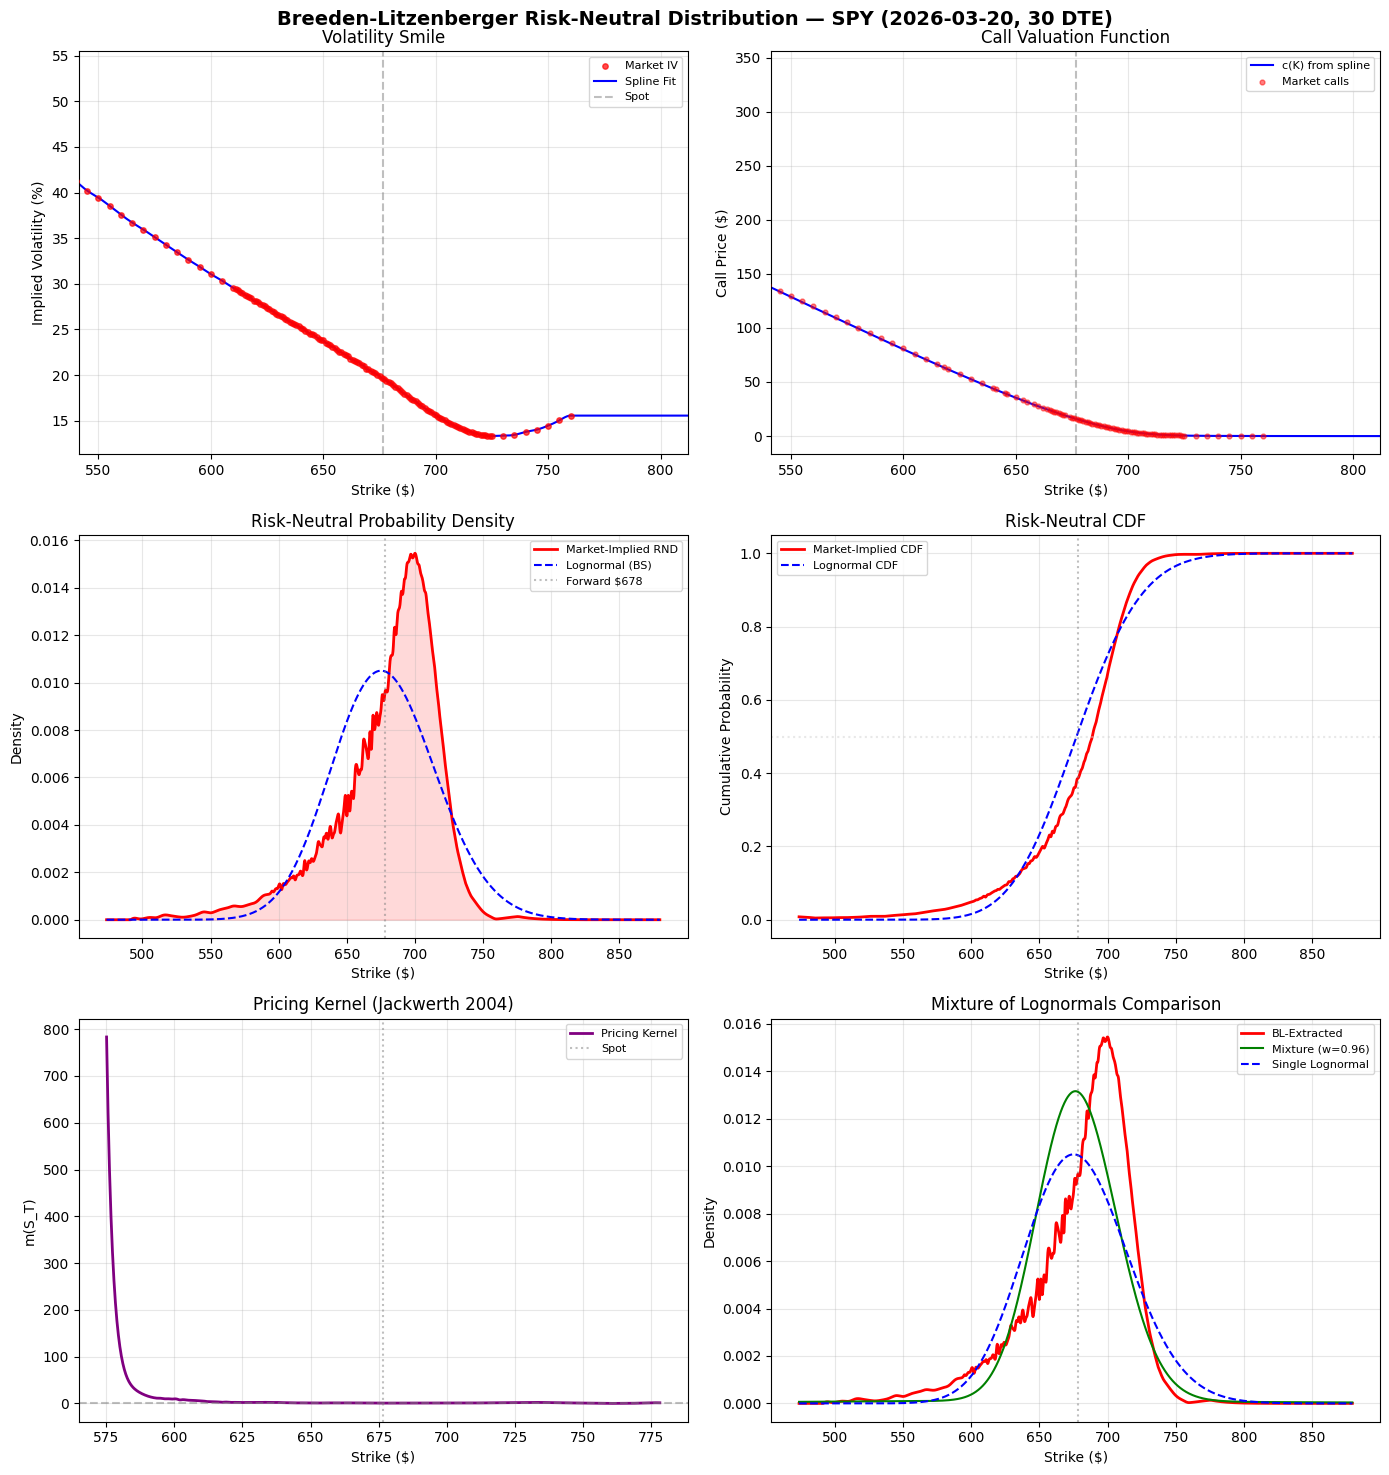

Figure saved to docs/notes/bl_summary.png


In [24]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle(f'Breeden-Litzenberger Risk-Neutral Distribution — {TICKER} ({selected_expiry}, {actual_dte} DTE)',
             fontsize=14, fontweight='bold')

# (1) Volatility Smile
ax = axes[0, 0]
ax.scatter(smile['strike'], smile['iv'] * 100, s=15, color='red', alpha=0.7, label='Market IV', zorder=5)
ax.plot(K_fine, sigma_fine * 100, 'b-', linewidth=1.5, label='Spline Fit')
ax.axvline(S0, color='gray', linestyle='--', alpha=0.5, label='Spot')
ax.set_xlabel('Strike ($)')
ax.set_ylabel('Implied Volatility (%)')
ax.set_title('Volatility Smile')
ax.legend(fontsize=8)
ax.set_xlim(S0 * 0.80, S0 * 1.20)
ax.grid(True, alpha=0.3)

# (2) Call Valuation Function
ax = axes[0, 1]
ax.plot(K_fine, C_fine, 'b-', linewidth=1.5, label='c(K) from spline')
ax.scatter(calls['strike'], calls['mid'], s=12, color='red', alpha=0.5, label='Market calls', zorder=5)
ax.axvline(S0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Strike ($)')
ax.set_ylabel('Call Price ($)')
ax.set_title('Call Valuation Function')
ax.legend(fontsize=8)
ax.set_xlim(S0 * 0.80, S0 * 1.20)
ax.grid(True, alpha=0.3)

# (3) Risk-Neutral PDF
ax = axes[1, 0]
ax.plot(K_rnd, rn_pdf_norm, 'r-', linewidth=2, label='Market-Implied RND')
ax.plot(K_rnd, lognorm_pdf, 'b--', linewidth=1.5, label='Lognormal (BS)')
ax.fill_between(K_rnd, rn_pdf_norm, alpha=0.15, color='red')
ax.axvline(F, color='gray', linestyle=':', alpha=0.5, label=f'Forward ${F:.0f}')
ax.set_xlabel('Strike ($)')
ax.set_ylabel('Density')
ax.set_title('Risk-Neutral Probability Density')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (4) Risk-Neutral CDF
ax = axes[1, 1]
ax.plot(K_rnd, rn_cdf, 'r-', linewidth=2, label='Market-Implied CDF')
ax.plot(K_rnd, lognorm_cdf, 'b--', linewidth=1.5, label='Lognormal CDF')
ax.axvline(F, color='gray', linestyle=':', alpha=0.5)
ax.axhline(0.5, color='lightgray', linestyle=':', alpha=0.5)
ax.set_xlabel('Strike ($)')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Risk-Neutral CDF')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (5) Pricing Kernel
ax = axes[2, 0]
ax.plot(K_rnd[pk_mask], pricing_kernel[pk_mask], '-', color='purple', linewidth=2, label='Pricing Kernel')
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(S0, color='gray', linestyle=':', alpha=0.5, label='Spot')
ax.set_xlabel('Strike ($)')
ax.set_ylabel('m(S_T)')
ax.set_title('Pricing Kernel (Jackwerth 2004)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# (6) Mixture vs BL-Extracted
ax = axes[2, 1]
ax.plot(K_rnd, rn_pdf_norm, 'r-', linewidth=2, label='BL-Extracted')
ax.plot(K_rnd, mixture_pdf, '-', color='green', linewidth=1.5, label=f'Mixture (w={w_fit:.2f})')
ax.plot(K_rnd, lognorm_pdf, 'b--', linewidth=1.5, label='Single Lognormal')
ax.axvline(F, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Strike ($)')
ax.set_ylabel('Density')
ax.set_title('Mixture of Lognormals Comparison')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/notes/bl_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved to docs/notes/bl_summary.png")